# Efficient Net - Establishing Baseline

Need to collect performance metrics 

https://docs.pytorch.org/vision/main/models/generated/torchvision.models.efficientnet_b6.html#torchvision.models.efficientnet_b6

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import torchvision
from PIL import Image
from torchvision import transforms, datasets, models
import os
import pandas as pd
from ISICDataset import ISICDataset, _find_image_path

In [2]:
#model = torchvision.models.efficientnet_b5(weights=torchvision.models.EfficientNet_B5_Weights.IMAGENET1K_V1)
model = torchvision.models.efficientnet_b3(weights=torchvision.models.EfficientNet_B3_Weights.IMAGENET1K_V1)

In [3]:
model_in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features=model_in_features, out_features=1)   # change to 1 for BCEWithLogitsLoss

In [4]:
train_path = os.path.join("../..", "train")
test_path = os.path.join("../..", "ISIC_2020_Test_Input")

In [5]:
df = pd.read_csv(os.path.join("../..", "ISIC_2020_Training_GroundTruth_v2.csv"))

In [6]:
df.head()

,image_name,patient_id,lesion_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,IL_7972535,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,IL_4649854,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,IL_9087444,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,IL_4255399,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,IL_6898037,female,55.0,upper extremity,unknown,benign,0


In [7]:
device = (
    torch.device("cuda")
    if torch.cuda.is_available()
    else torch.device("mps") if torch.backends.mps.is_available()
    else torch.device("cpu")
)

In [8]:
# Configuration
IMG_SIZE = 456  # EfficientNet-B5 expected input size
BATCH_SIZE = 16
VAL_FRAC = 0.1
SEED = 42

# Build file path column and drop missing files
df_files = df.copy()
df_files["filepath"] = df_files["image_name"].apply(lambda x: _find_image_path(x, train_path))
missing = df_files["filepath"].isna().sum()
if missing:
    print(f"Dropping {missing} rows: image files not found in {train_path}")
df_files = df_files.dropna(subset=["filepath"]).reset_index(drop=True)
print(f"Using {len(df_files)} samples for training/validation")

# Transforms
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.02),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
])

val_transform = transforms.Compose([
    transforms.Resize(int(IMG_SIZE * 1.14)),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
])

# Split into train / val
n = len(df_files)
n_val = int(n * VAL_FRAC)
n_train = n - n_val
g = torch.Generator().manual_seed(SEED)
perm = torch.randperm(n, generator=g).tolist()
train_idx = perm[:n_train]
val_idx = perm[n_train:]

train_df = df_files.iloc[train_idx].reset_index(drop=True)
val_df = df_files.iloc[val_idx].reset_index(drop=True)

train_dataset = ISICDataset(train_df, transform=train_transform)
val_dataset = ISICDataset(val_df, transform=val_transform)

Using 33126 samples for training/validation


In [9]:
# DataLoaders
num_workers = 0#min(8, (os.cpu_count() or 1))
pin_memory = torch.cuda.is_available()

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=num_workers, pin_memory=pin_memory)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE * 2, shuffle=False,
                        num_workers=num_workers, pin_memory=pin_memory)

print(f"train samples: {len(train_dataset)}, val samples: {len(val_dataset)}")

train samples: 29814, val samples: 3312


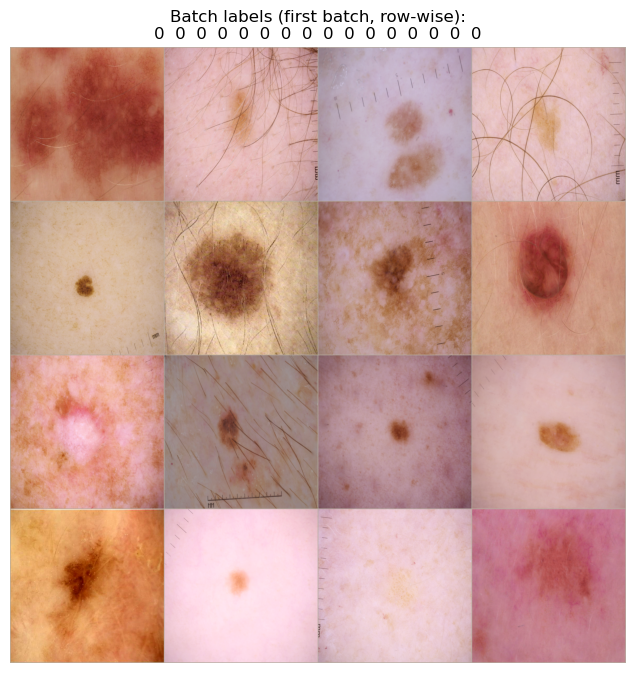

In [10]:
from torchvision.utils import make_grid
import numpy as np

import matplotlib.pyplot as plt

# grab first batch
images, labels = next(iter(train_loader))  # images: (B, C, H, W)

# make a grid
nrow = 4
grid = make_grid(images, nrow=nrow, pad_value=1)

# un-normalize (imagenet)
grid = grid.cpu()
for c in range(3):
    grid[c] = grid[c] * imagenet_std[c] + imagenet_mean[c]

np_img = grid.permute(1, 2, 0).numpy()
np_img = np.clip(np_img, 0, 1)

plt.figure(figsize=(12, 8))
plt.imshow(np_img)
plt.axis("off")

# show labels for the images in the grid (row-wise)
labels_list = labels.tolist()
labels_str = "  ".join(str(x) for x in labels_list[: min(len(labels_list), BATCH_SIZE)])
plt.title("Batch labels (first batch, row-wise):\n" + labels_str)
plt.show()

## Training Baseline

In [11]:
lr = 1e-4
num_epochs = 25
scheduler_patience = 3
checkpoint_path = "./checkpoints"
run_name = "efficientnet_b3_isic2020"

In [12]:
loss_function = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.1, patience=scheduler_patience)

In [13]:
from train import train_model

train_losses, val_losses, metadata = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=loss_function,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=25,
    checkpoint_path="./checkpoints",
    run_name="efficientnet_b3_finetune",
    device=device
)

KeyboardInterrupt: 